<a href="https://colab.research.google.com/github/ajasja/PROPER/blob/main/PROPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROPER -- Single-chain permuted proteins for dimerization-based control of protein activity and cellular processes

Strategies for detecting and controlling protein interactions play a critical role in gaining an insight into molecular mechanisms of biological processes and for the control of cellular processes. Conditional protein reconstitution allows control of the selected protein function based on the proximity, defined by the genetically fused domain pairs, which may be regulated by chemical or biological signals. This typically requires two protein components in a stoichiometric ratio, which increases the complexity and genetic footprint with split segments often being unstable and prone to aggregation. To overcome this limitation, we developed an approach based on a permuted protein reconstitution by conditional dimerization (PROPER). According to this strategy, the N- and C-terminal domains of selected proteins are swapped and a loop replaced by a short linker that prevents the functionality of a monomeric protein, which reconstitutes only upon di- or oligomerization, controlled by a genetically fused domain that dimerizes by a chemical signal or senses a dimeric target.

This notebook enables the design of permuted "PROPER" proteins.

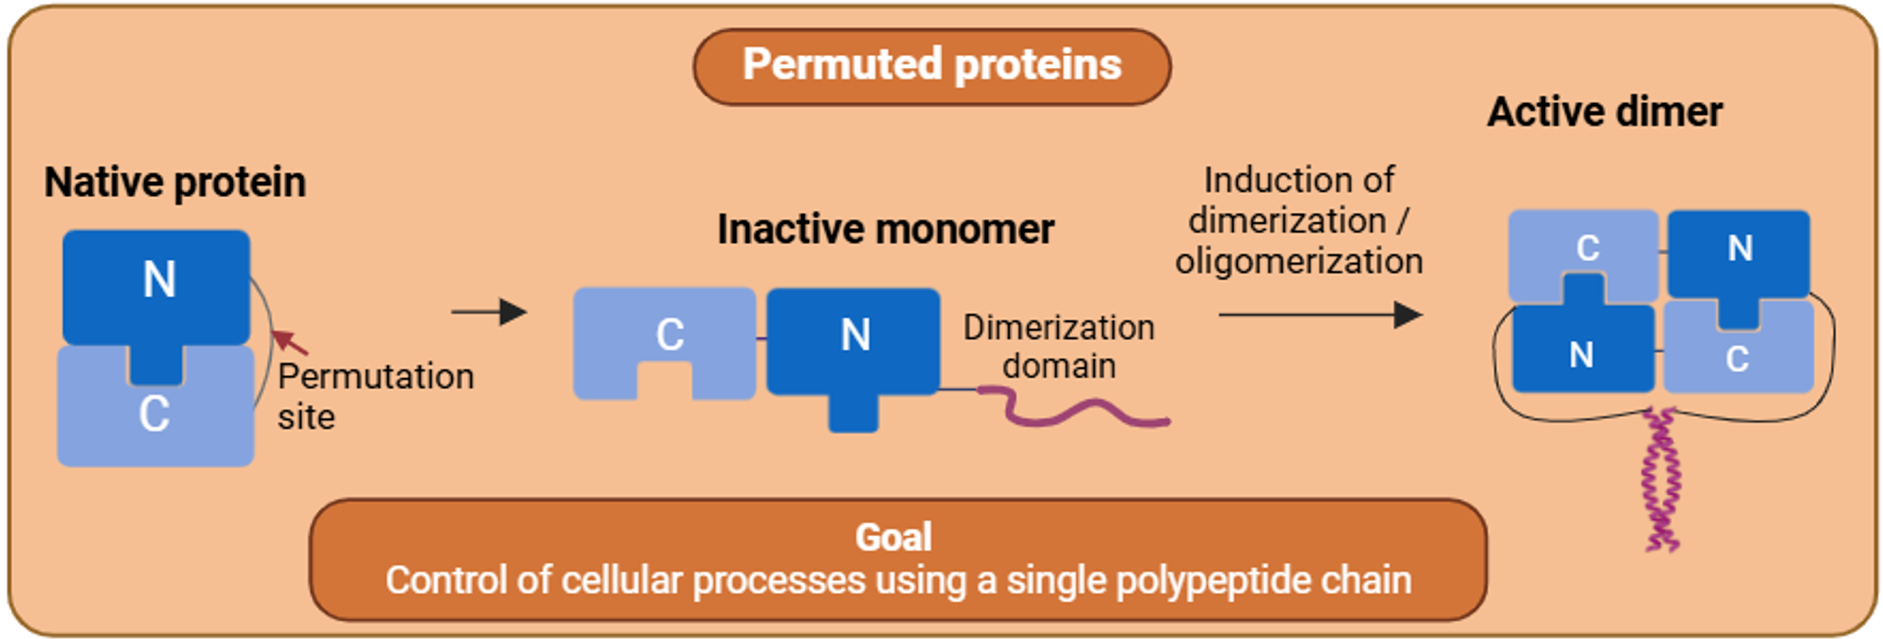

In [ ]:
#@title Setup and import packages
#@markdown This step takes ~1 minute.
!pip -q install py3Dmol biopython mdtraj pdb-tools
import py3Dmol
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets.widgets import IntSlider, Layout, FloatSlider, Checkbox, ToggleButtons, HBox, VBox, Button, Text
from pathlib import Path

! pip install -q --upgrade git+https://github.com/ajasja/PROPER.git

# sample data
!wget -q https://raw.githubusercontent.com/ajasja/PROPER/refs/heads/main/example_data/TEVp_full.pdb

import proper

In [ ]:
from logging import exception
#@title Upload pdb
#@markdown Please enter a PDB ID or leave empty to upload your own PDB structure.
#@markdown
#@markdown A "Choose Files" button that will appear below after running this cell.
#@markdown Structure will be re-numbered starting from 1.
#@markdown Currently only single chain proteins are supported

#@markdown
#@markdown **Note:** check that the PDB file is not missing loops or residues!

from google.colab import files
from pathlib import Path
import os

pdb = "TEVp_full.pdb" #@param {type:"string"}
#chain_ID = "A" #@param {type:"string"}


def get_pdb(pdb_code=None):
  if len(pdb_code) == 4:
    !pdb_fetch -biounit {pdb_code} > {pdb_code}.pdb
    print(f"Downloaded {pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif pdb_code.strip() == "":
    upload_dict = files.upload()
    pdb_string = list(upload_dict.keys())[0]
    return pdb_string
  else:
    raise Exception("invalid PDB code")

up_file_name = get_pdb(pdb_code=pdb)
up_file_stem = Path(up_file_name).stem
proper.clean_pdb(up_file_name)

with open(up_file_name, 'r') as file:
    model = file.read()


from Bio.PDB import PDBParser, PPBuilder, PDBIO

analyzer=proper.LoopAnalyzer(up_file_name, include_dssp='L', skip_ends=True)
print('Seq:'+analyzer.seq)

Executing the next cell will create an interactive GUI where the best permutation sites can will be suggested and visualised.

1) Click `Suggest best sites` to sugest permutation sites. You can freely edit the suggested sites and the linkers used to generate permutations.

2) Click `Save permuted sequences` to save (download) the permuted sequnces to a fasta file. The `*permuted-dimers.fasta` file should be used in the next step for structure prediction.





In [ ]:
#@title Obtain suggestions

from pathlib import Path

out = widgets.Output(layout=widgets.Layout(border= '1px solid black',
    width='800px',   # fixed width
    height='180px',  # fixed height
    overflow='auto'  # enable scrollbars if content overflows})
))
out.layout.overflow = "scroll"
out.layout.flex_flow = "wrap-reverse"



p = py3Dmol.view(width=800, height=480)

p.addModels(model, "pdb")

p.setStyle({'cartoon': {'color':'spectrum'}})

p.zoomTo()
p.show()

# globals
suggestions_made = False
positions1 = []
fasta_file_name = ''
dimers_fasta_file_name = ''


####################################
### EVENTS #########################
####################################

def on_position_change(change):
    p.addStyle({'sphere':{'hidden':True}});
    p.addStyle({'resi': position.value, 'atom': 'CA'},
     {'sphere':{'color': 'orange', 'scale':1, 'hidden':False}});
    if positions1:
        for pos in positions1:
            if pos != position.value:
                p.addStyle({'resi': pos, 'atom': 'CA'},
                 {'sphere':{'color': 'green', 'opacity':0.5, 'scale':0.5, 'hidden':False}});
    p.update()

def on_find_pos_click(change):
    with out:
      global suggestions_made, analyzer, positions1, selected_positions_input, one_site_per_loop_checkbox
      print('Suggesting sites...')
      permutation_sites = analyzer.suggest_sites('resi_burial_percent<50', one_site_per_loop=one_site_per_loop_checkbox.value)
      print('Done...')
      positions1 = list(permutation_sites.resi_index0+1)
      selected_positions_input.value = ",".join(str(i) for i in positions1)
      #print(selected_positions_input.value)
      suggestions_made = True
      on_position_change(change)




def on_save_features_click(change):
  with out:
    base_name = Path(up_file_name).with_suffix('')
    feat_name = base_name.with_suffix('.features.xlsx')
    desc_name = base_name.with_suffix('.descriptions.xlsx')
    print(f'Saving {feat_name}')
    analyzer.residue_features_table.to_excel(feat_name)
    print(f'Saving {desc_name}')
    analyzer.feature_descriptions_table.to_excel(desc_name)
    from google.colab import files
    files.download(feat_name)
    files.download(desc_name)

    print("Features saved!")

def on_selected_positions_change(change):
  global positions1, selected_positions_input
  with out:
    positions1 = [int(i) for i in selected_positions_input.value.split(',')]
    print('New positions:'+selected_positions_input.value)
    on_position_change(change)

def on_generate_fasta_click(change):
  global analyzer, positions1, fasta_file_name, dimers_fasta_file_name

  if selected_positions_input.value=='':
    on_find_pos_click(change)
  with out:
    fasta_file_name = name_input.value + '_permuted.fasta'
    dimers_fasta_file_name = name_input.value + '_permuted-dimers.fasta'
    linkers = proper.load_fasta_or_single_line(linker_input.value)
    proper.generate_permuted_sequences(name_input.value, analyzer.seq, linkers, positions1, fasta_file_name)
    proper.make_dimers_fasta(fasta_file_name, dimers_fasta_file_name)
    #print(proper.file_to_str(fasta_file_name))


def on_save_perm_fasta(change):
  global analyzer, positions1, fasta_file_name, dimers_fasta_file_name, save_monomer_fasta_checkbox
  with out:
    if fasta_file_name=='':
      on_generate_fasta_click(change)
    from google.colab import files

    if save_monomer_fasta_checkbox.value:
      print(f'Downloading: {fasta_file_name}')
      files.download(fasta_file_name)
    print(f'Downloading: {dimers_fasta_file_name}')
    files.download(dimers_fasta_file_name)


    #files.download(dimers_fasta_file_name)


####################################
### USER INTERFACE #################
####################################

wide_layout = dict(description_width="initial")
position=IntSlider(min=1, max=len(analyzer.seq), value=1, step=1, continuous_update=True,
                  description='current position',
                  tooltip='Position of permutation', style=wide_layout)
position.observe(on_position_change, names='value')
on_position_change(position)

find_pos=Button(description='Suggest best sites', tooltip='Suggest best permutation sites')
find_pos.on_click(on_find_pos_click)
find_pos.style.button_color = 'lightgreen'

save_features=Button(description='Save features', tooltip='Save the features used suggesting')
save_features.on_click(on_save_features_click)


name_input = widgets.Text(
    value=up_file_stem,
    description='Name of structure:',
    style = wide_layout
)



selected_positions_input = widgets.Text(
    value='',
    description='Selected positions:',
    style = wide_layout,
    layout=widgets.Layout(width='600px'),
    continuous_update=False,
)
selected_positions_input.observe(on_selected_positions_change, names=['value'])


one_site_per_loop_checkbox = widgets.Checkbox(
    value=True,
    description='One site per loop:',
)

def_linkers ="""\
>08AA
GSGSGSGS
>12AA
GSGSGSGSGSGS
>20AA
GAGGEGSGGGSGGKGSGGT
>SAH12
EEEEKKKKEEEE
"""

linker_input = widgets.Textarea(
    value=def_linkers,
    placeholder='Enter linkers here',
    description='Linkers:',
    layout=widgets.Layout(width='800px', height='120px'),
    style={'description_width': 'initial'}
)


generate_perm_fasta_btn=Button(description='Generate permutations!',
                               tooltip='Generate permutations from positions and linkers',
                               style = wide_layout,)

generate_perm_fasta_btn.on_click(on_generate_fasta_click)
#generate_perm_fasta_btn.style.button_color = 'lightgreen'
generate_perm_fasta_btn.layout.width = '200px'


save_fasta_btn=Button(description='Save permuted sequences', tooltip='Save the permuted sequences to fasta files')
save_fasta_btn.style.button_color = 'lightgreen'
save_fasta_btn.layout.width = '200px'
save_fasta_btn.on_click(on_save_perm_fasta)

save_monomer_fasta_checkbox = widgets.Checkbox(
    value=False,
    description='Save monomer fasta file',
)

display(
    HBox([name_input,  widgets.Label("Residues are counted from 1 to N. Make sure there are no breaks in the 3D structure." )]),
    HBox([position]),
    HBox([find_pos, one_site_per_loop_checkbox, save_features]),
    HBox([selected_positions_input]),
    HBox([linker_input]),
    HBox([generate_perm_fasta_btn, save_fasta_btn, save_monomer_fasta_checkbox]),
    widgets.Label("Output:"),
    HBox([out]),

)


# Structure prediction

For tehnical reasons (structure prediction requires a colab enviorment with a GPU) the model generation is acomplished in a seperate notebook.


1) Upload the `*permuted-dimers.fasta` to the following notebook:
**[ESMFold_fasta](https://colab.research.google.com/github/ajasja/PROPER/blob/main/ESMFold_fasta.ipynb)**.

The strucutres with the highest pTM are more likely correct.

---

1b) Alternatively in rare cases AF2 gives better results: [AlphaFold2_batch.ipynb](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb)